# Assignment 5

This assignment introduces a tutorial for multiple regression model by using a dataset collected from a A/B testing experiment of headlines. 

This dataset is shared by this [study](https://www.nature.com/articles/s41562-023-01538-4).

This dataset includes the following variables:

| Column | Description|
|--------| -----------|
|id	|Headline id|
|headline	|Headline text|
|clickability_test_id|The group id for the A/B testing. Each group has the same article content with different headlines to be tested.|
|relative_date | The age of the news article (as dates)|
|word_count |	Word counts of the headline|
|readability_fog | The readability of the headline|
|liwc_posemo | The percentage of positive words in the headline|
|liwc_negemo| The percentage of the negative words in the headline|
|clicks |	Number of clicks of the headline|
|impressions |	Number of times this headline is being viewed by audiences|
|click_rate |	The click-through-rate measured as clicks/impressions|

The goal of this experiment and this dataset is to test whether or not negativity or positivity impacts the click-through-rate of the news headline. 

**To complete this assignment, you need to run this tutorial and obtain the results of the analysis, and answer the questions which will help you generate a report of this analysis.**

## Loading packages

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import logit, expit
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## Define functions to plot the diagnostic plots

In [2]:
def plot_diagnostic_regression(model_result):
    fig, ax = plt.subplots(2, 2, figsize=(8,9))
    model_fitted_value = model_result.fittedvalues
    model_residuals = model_result.resid
    model_norm_residuals = model_result.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    model_leverage = model_result.get_influence().hat_matrix_diag
    
    sm.qqplot(model_residuals, fit=True, line="45", ax=ax[0,0])
    ax[0,0].set_title('Residuals Q-Q Plot')
    
    sns.residplot(x=model_fitted_value, y=model_residuals, 
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[0,1])
    ax[0,1].set_title('Residuals vs Fitted')
    ax[0,1].set_xlabel('Fitted values')
    ax[0,1].set_ylabel('Residuals');
    
    
    sns.regplot(x=model_fitted_value,
                y= model_norm_residuals_abs_sqrt,
                  ci=False,
                  lowess=True,
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[1,0]);
    ax[1,0].set_title('Scale-Location')
    ax[1,0].set_xlabel('Fitted values')
    ax[1,0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    
    sns.regplot(x=model_leverage, y=model_norm_residuals,
                  ci=False,
                  lowess=True,
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax[1,1])
    
    ax[1,1].set_title('Residuals vs Leverage')
    ax[1,1].set_xlabel('Leverage')
    ax[1,1].set_ylabel('Standardized Residuals')
    plt.show()

## Load our data

In [3]:
df = pd.read_csv("negativity_bias_regression_df.csv")

### show the first five rows of the data

In [4]:
df.head()

,Unnamed: 0,clickability_test_id,headline,id,relative_date,word_count,readability_fog,liwc_posemo,liwc_negemo,clicks,impressions,click_rate
0,0,5143605e220cb80002000076,"Here's The Science, Here's The Gay. Open Your ...",40471,52,14,2.800000,0.000000,0.000000,54,4069,0.013271
1,1,5143605e220cb80002000076,"Hey Dude. If You Have An Older Brother, There'...",40470,52,14,2.800000,0.000000,0.000000,41,4080,0.010049
2,2,5143605e220cb80002000076,I've Got Some News For You. Being Gay Is Genet...,40472,52,18,6.844444,0.052632,0.052632,40,4160,0.009615
3,3,5143605e220cb80002000076,If You Know Anyone Who Is Afraid Of Gay People...,40474,52,20,12.000000,0.047619,0.047619,120,4155,0.028881
4,4,5143605e220cb80002000076,"SCIENCE FACT: Gay Science, Like Straight Scien...",40473,52,14,5.600000,0.000000,0.000000,32,4132,0.007744


## Preliminary model fitting with our variables of interest

This model fitting is the following:

$$
Click\_through\_rate \sim positive\_words + negative\_words
$$

which is equivalent to the following regression model expression:

$$
Click\_through\_rate_i = \beta_0 + \beta_1 * positive\_words_i + \beta_2 * negative\_words_i + \epsilon_i
$$
$$
\epsilon_i \sim N(0, \sigma^2)
$$

In [5]:
model_preliminary = smf.ols("click_rate ~ liwc_posemo + liwc_negemo", df).fit()
model_preliminary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             click_rate   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     157.1
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           9.44e-69
Time:                        02:27:39   Log-Likelihood:             1.6380e+05
No. Observations:               53699   AIC:                        -3.276e+05
Df Residuals:                   53696   BIC:                        -3.276e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0134   6.96e-05    191.780      0.000       0.013       0.013
liwc_posemo     0.0008      0.001      0.794      0.427      -0.001       0.003
liwc_negemo     0.0199      0.001     17.718      0.000       0.018       0.022
==============================================================================
Omnibus:                    29005.290   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           293167.744
Skew:                           2.420   Prob(JB):                         0.00
Kurtosis:                      13.374   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

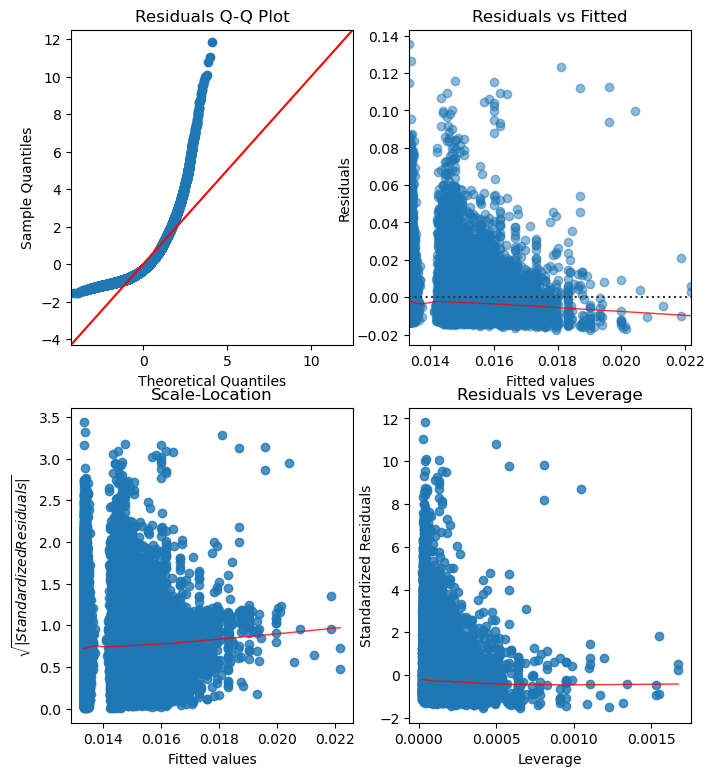

In [6]:
plot_diagnostic_regression(model_preliminary)

# Question 1:

1. From the preliminary model fitting result, report the t-test result and the F-test results following APA style. 
2. What is the F result telling us?
3. How to interpret the regression coefficients for our independent variables?
4. By looking at the diagnostic plots, what issues do you observe?

## Transforming the dependent variable

The click-through-rate is an empirical probability metric, measuring the probability of people click into the headline. One way to transform this probability metric is through a $logit$ function. 

$$
logit(p) = log(\frac{p}{1-p})
$$

In this case, we transformed the click-through-rate using a logit function. Since the log function will generate $inf$ values for $p=0$ or $p=1$, we need to filter out these values in our data. 

In [7]:
df["logit_click_rate"] = logit(df.click_rate)

In [8]:
df = df[~(df.logit_click_rate==-np.inf)]

## Exploratory Analysis

We can plot the pairwise scatterplots and the correlation heatmap to discover the correlations and distributions of our data.

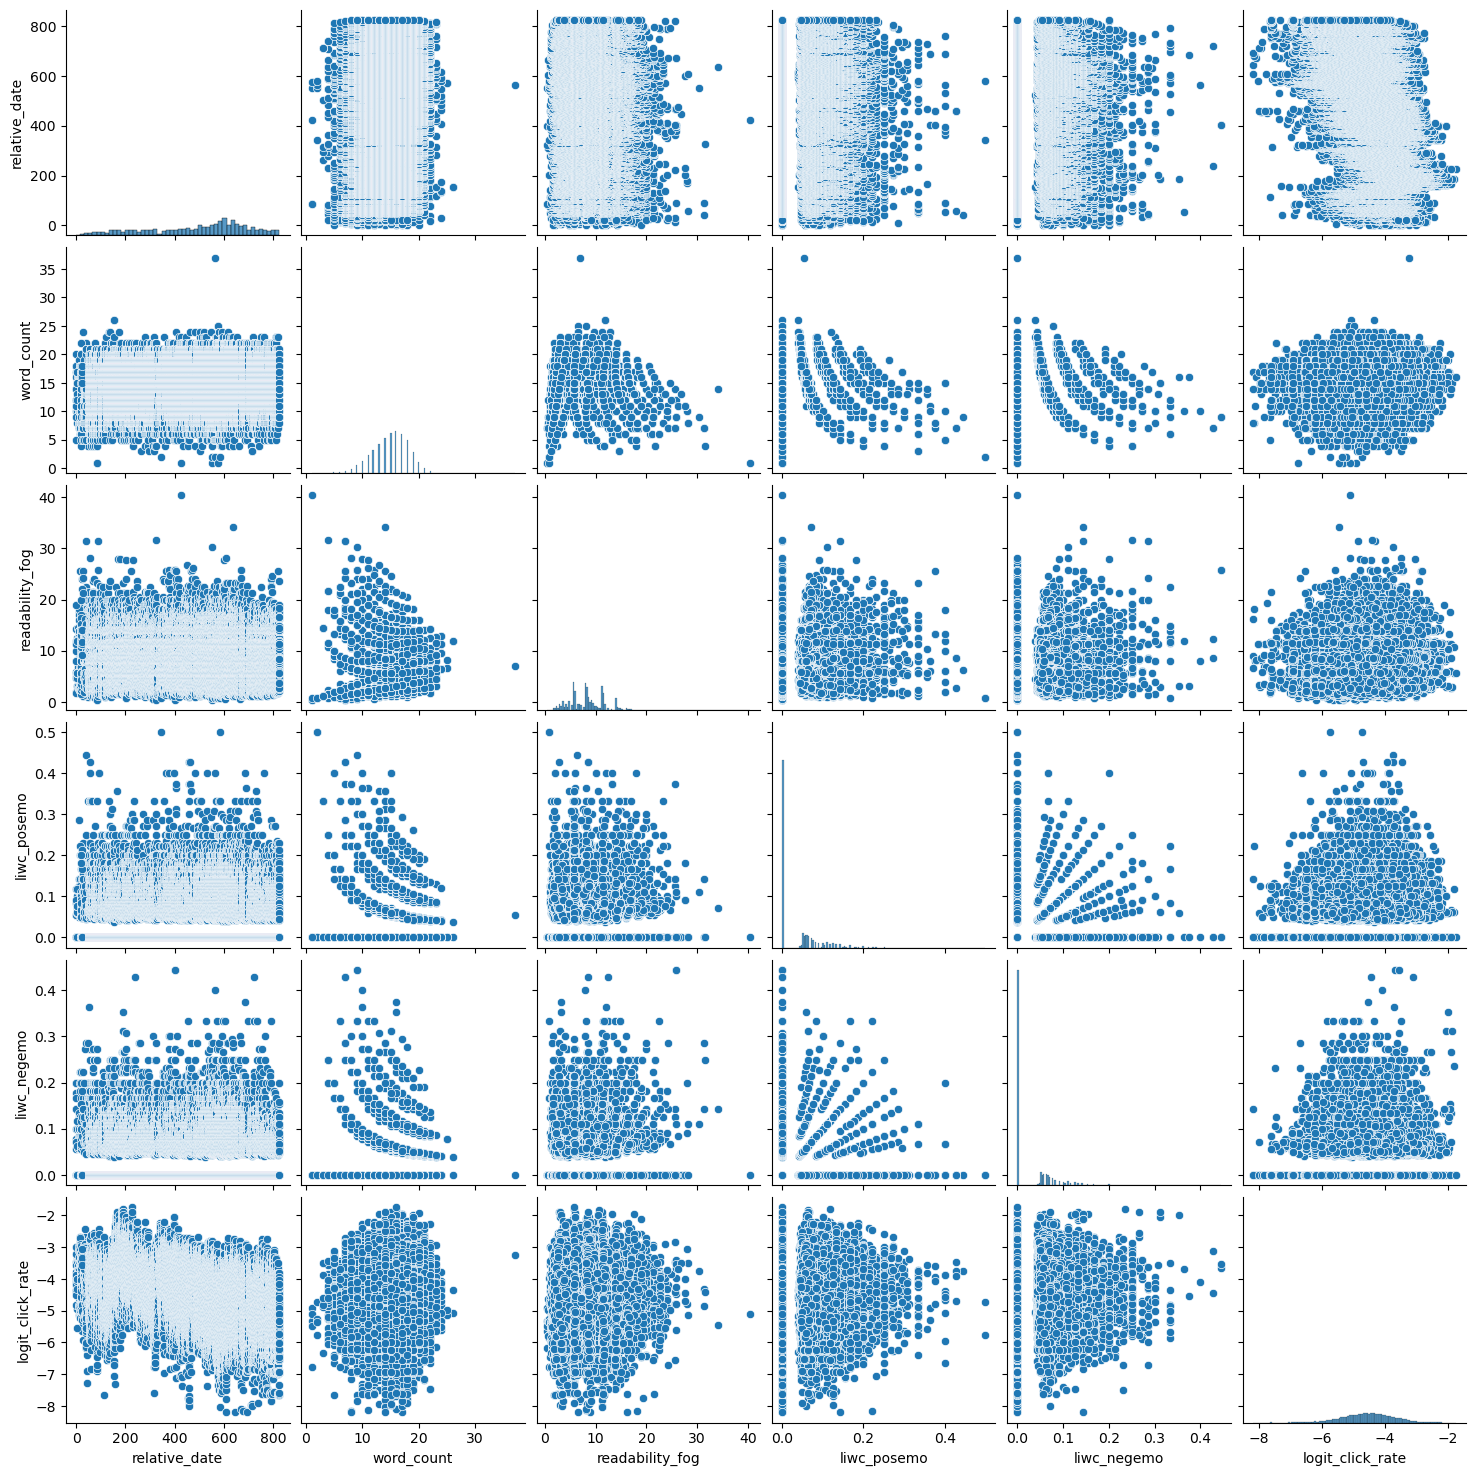

In [9]:
sns.pairplot(data=df, 
             vars=["relative_date", "word_count", "readability_fog", "liwc_posemo", "liwc_negemo", "logit_click_rate"])
plt.show()

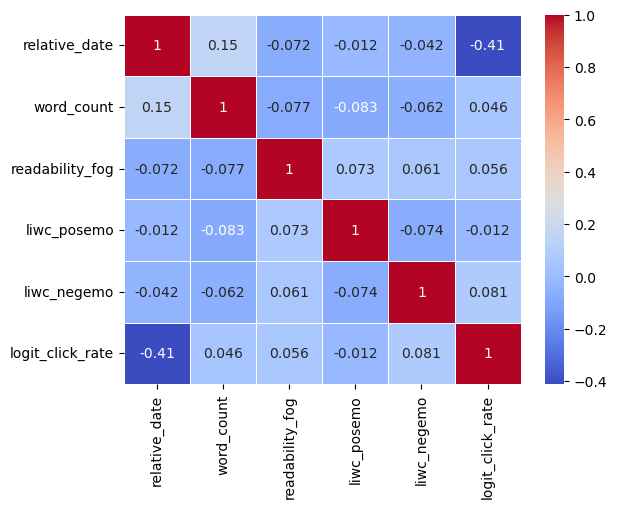

In [10]:
corr_matrix = df[["relative_date", "word_count", "readability_fog", "liwc_posemo", "liwc_negemo", "logit_click_rate"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

## Preliminary model with transformed dependent variable

Now, we fit the model again with the transformed variable. 

In [11]:
model_transformed = smf.ols("logit_click_rate ~ liwc_posemo + liwc_negemo", df).fit()
model_transformed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       logit_click_rate   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     177.8
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           1.05e-77
Time:                        02:27:53   Log-Likelihood:                -62969.
No. Observations:               53659   AIC:                         1.259e+05
Df Residuals:                   53656   BIC:                         1.260e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.5802      0.005   -962.797      0.000      -4.590      -4.571
liwc_posemo    -0.0955      0.066     -1.447      0.148      -0.225       0.034
liwc_negemo     1.4292      0.077     18.646      0.000       1.279       1.579
==============================================================================
Omnibus:                      332.581   Durbin-Watson:                   0.629
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.868
Skew:                          -0.179   Prob(JB):                     1.30e-75
Kurtosis:                       3.160   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

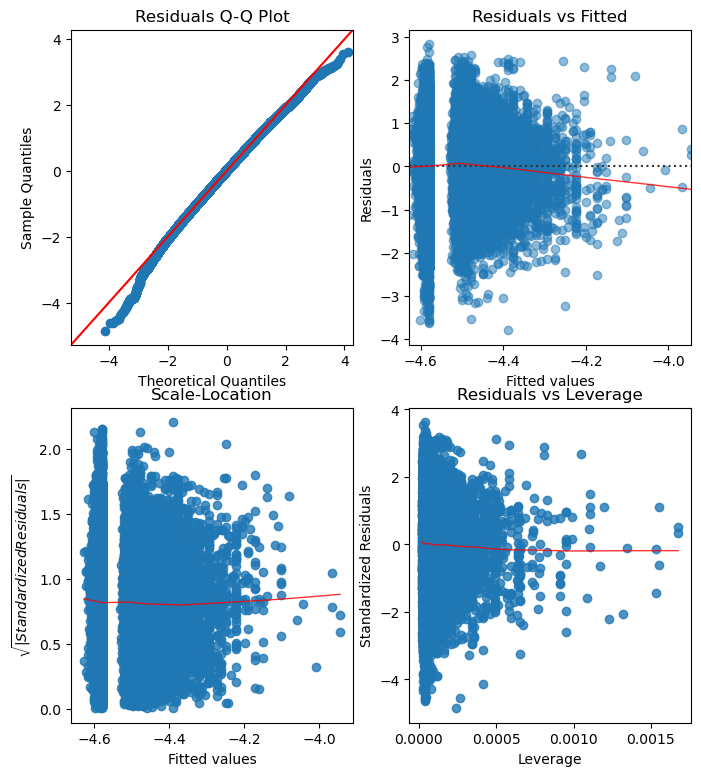

In [12]:
plot_diagnostic_regression(model_transformed)

## Question 2
1. Did this transformation help some of the problem you identified in the previous model? Which issue did it improved? And which issue it did not improve?

## Hierachical Regression Model for Controlling Variables

In our modeling, we are interested in how negative words and positive words impact the click-through-rate of headlines. But from our exploratory analysis, we found out that some other variables also impact the click-through-rate, thus could be a potential counfounding variable. It means that these variables, such as readability, age of the article, and length of the headline could explain the effect of positive words and negative words in our previous model. 

To address this issue, we can fit a hierachical regression model, by comparing a reduced model (with only control variables), and a full model (with both control variables and variables of interest). 

In [13]:
model_control = smf.ols("logit_click_rate ~ relative_date + word_count + readability_fog", df).fit()
model_full = smf.ols("logit_click_rate ~ relative_date + word_count + readability_fog + liwc_posemo + liwc_negemo ", df).fit()

### General Linear Test

We can compare these two models by applying a general linear test, by an ANOVA test. 

In [14]:
sm.stats.anova_lm(model_control, model_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,53655.0,27013.963318,0.0,NaN,NaN,NaN
1,53653.0,26858.732203,2.0,155.231115,155.044827,7.223099e-68


## Question 3

1. Write a report for this F-test with a few sentences, introducing what test is conducted, purpose of this test, and report the test statistics.
2. What does this F test tell us?

## Full model t test

For the full model including all of our independent variables, we can generate a result report.

In [15]:
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       logit_click_rate   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     2478.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:27:54   Log-Likelihood:                -57571.
No. Observations:               53659   AIC:                         1.152e+05
Df Residuals:                   53653   BIC:                         1.152e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.2826      0.018   -232.699      0.000      -4.319      -4.246
relative_date      -0.0016    1.5e-05   -107.622      0.000      -0.002      -0.002
word_count          0.0295      0.001     29.529      0.000       0.028       0.031
readability_fog     0.0066      0.001      7.809      0.000       0.005       0.008
liwc_posemo        -0.0736      0.060     -1.225      0.220      -0.191       0.044
liwc_negemo         1.2121      0.070     17.403      0.000       1.076       1.349
==============================================================================
Omnibus:                      760.283   Durbin-Watson:                   0.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              810.401
Skew:                          -0.276   Prob(JB):                    1.06e-176
Kurtosis:                       3.242   Cond. No.                     1.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

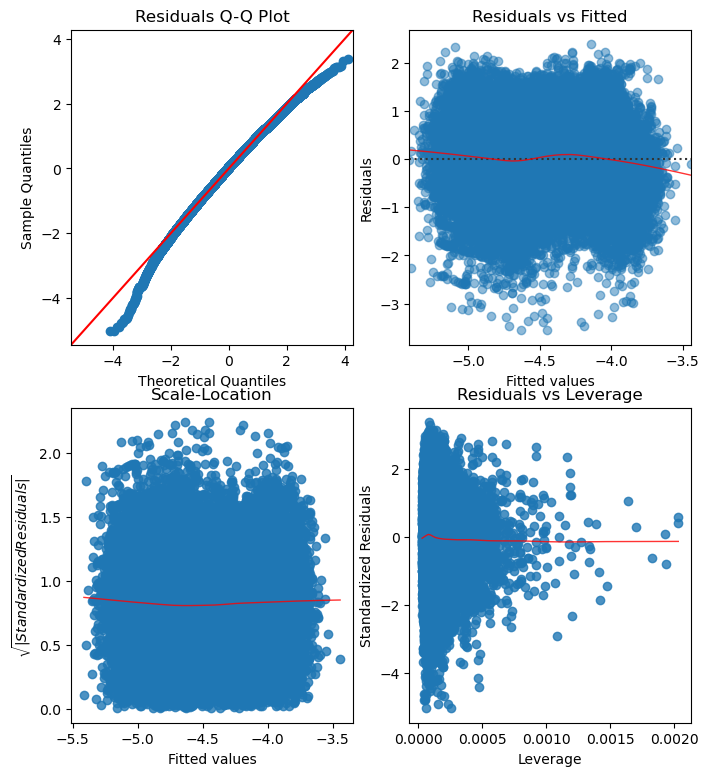

In [16]:
plot_diagnostic_regression(model_full)

## VIF test for independent variables

In [17]:
X = add_constant(df[["relative_date", "word_count", "readability_fog", "liwc_posemo", "liwc_negemo"]])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const              36.305137
relative_date       1.028745
word_count          1.038435
readability_fog     1.018030
liwc_posemo         1.018649
liwc_negemo         1.015056
dtype: float64

## Question 4
1. Write down the regression model specification for the full model. 
2. Report the t-test results for variables of interest.
3. Report the F-test result.
4. By the diagnostic plots and the VIF test, what issue do you observe? 

## Advanced Part: Mixed Effect Models

One critical issue in our previous analysis is that our data is not independent. This is because for the headline A/B testing experiment, multiple rows of data (headlines) were generated and assigned to groups of tests (denoted by `clickability_test_id`). 

Thus, the samples are not i.i.d samples. To mitigate this issue, we can fit a mixed effect model, which integrate the group structure in our data into our model. 

The first thing to estimate a mixed effect model is to scale (standardize) the independent variables.

In [18]:
for col in ["relative_date", "word_count", "readability_fog", "liwc_posemo", "liwc_negemo"]:
    df.loc[:,col+"_scaled"] = (df[col] - df[col].mean())/df[col].std()

/tmp/ipykernel_1866860/613900368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,col+"_scaled"] = (df[col] - df[col].mean())/df[col].std()
/tmp/ipykernel_1866860/613900368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,col+"_scaled"] = (df[col] - df[col].mean())/df[col].std()
/tmp/ipykernel_1866860/613900368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

## Random Intercept Model

Then, we can estimate a random intercept model, which specify that each group of the tested headlines will have the same intercept, while the intercept can change across different groups of headlines. 

The model is the following:

$$
Logit\_Click\_Through\_Rate_{i,j} = \beta_{0,j} + \beta_1 * Headline\_Age_i + \beta_2 * Word\_count + \beta_3 * Readability_i + \beta_4 * Positive\_words_i + \beta_5 * Negative\_words_i + \epsilon_i
$$

The main difference between this random intecept model and the previous full model is that, this random intercept model allows the intercept $\beta_{0,j}$ to vary across different groups $j$, thus address the independence issue in our previous models and potentially improve our model results.

We can use the `mixedlm` function from `statsmodel` to fit this model, by specifying a `group` argument.

In [19]:
model_mixed_random_intercept = smf.mixedlm("logit_click_rate ~ relative_date_scaled + word_count_scaled" + 
                                           " + readability_fog_scaled + liwc_posemo_scaled + liwc_negemo_scaled", df,
                                    groups=df["clickability_test_id"])
model_mixed_random_intercept_result = model_mixed_random_intercept.fit(method=["lbfgs"])

In [20]:
model_mixed_random_intercept_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:               MixedLM  Dependent Variable:  logit_click_rate
No. Observations:    53659    Method:              REML            
No. Groups:          12445    Scale:               0.1324          
Min. group size:     1        Log-Likelihood:      -37736.5501     
Max. group size:     17       Converged:           Yes             
Mean group size:     4.3                                           
-------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept              -4.525    0.006 -786.987 0.000 -4.536 -4.514
relative_date_scaled   -0.319    0.006  -57.178 0.000 -0.330 -0.308
word_count_scaled       0.051    0.002   23.834 0.000  0.047  0.055
readability_fog_scaled  0.003    0.002    1.238 0.216 -0.002  0.007
liwc_posemo_scaled     -0.011    0.002   -5.335 0.000 -0.015 -0.007
liwc_negemo_scaled      0.022    0.002   10.372 0.000  0.018  0.026
Group Var               0.375    0.016                             
===================================================================

"""

As you can see, this model improved our model, and increased our power to detect the effect of positive words on headline click-through rate. 

## Random Slope Model

Take one step further, we can also specify that the regression coeffcients (slopes) can change across different groups, not just the intercept. 

In this case, we will have to estimate a fixed effect for our independent variables (contant effects of independent variables across groups), and also a random effect (variability of effects of independet variables across groups). 

The model specification is the following

$$
Logit\_Click\_Through\_Rate_{i,j} = \beta_{0,j} + \beta_1 * Headline\_Age_i + \beta_{2,j} * Word\_count + \beta_{3,j} * Readability_i + \beta_{4,j} * Positive\_words_i + \beta_{5,j} * Negative\_words_i + \epsilon_i
$$

Note that we now allows the regression coefficients to vary across different groups. 

Also note that since the headline age is constant within the group, we should not specify it as a random slope, otherwise it will cause an identifiability issue in our model fitting. 

Now, we estimate our model by using the `re_formula` argument in our model. 

In [21]:
model_mixed_random_slopes = smf.mixedlm("logit_click_rate ~ relative_date_scaled + word_count_scaled" + 
                                        " + readability_fog_scaled + liwc_posemo_scaled + liwc_negemo_scaled", df,
                                    groups=df["clickability_test_id"],
                                       re_formula="~liwc_posemo_scaled + liwc_negemo_scaled + word_count_scaled + readability_fog_scaled")

In [22]:
model_mixed_random_slopes_result = model_mixed_random_slopes.fit(method=["lbfgs"])

/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [23]:
model_mixed_random_slopes_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
============================================================================================
Model:                      MixedLM           Dependent Variable:           logit_click_rate
No. Observations:           53659             Method:                       REML            
No. Groups:                 12445             Scale:                        0.1192          
Min. group size:            1                 Log-Likelihood:               -37549.1276     
Max. group size:            17                Converged:                    Yes             
Mean group size:            4.3                                                             
--------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                       -4.526    0.006 -787.289 0.000 -4.537 -4.514
relative_date_scaled                            -0.320    0.006  -57.301 0.000 -0.331 -0.309
word_count_scaled                                0.050    0.002   21.703 0.000  0.046  0.055
readability_fog_scaled                           0.002    0.002    0.842 0.400 -0.003  0.007
liwc_posemo_scaled                              -0.010    0.002   -4.546 0.000 -0.015 -0.006
liwc_negemo_scaled                               0.022    0.002    9.750 0.000  0.018  0.027
Group Var                                        0.370    0.018                             
Group x liwc_posemo_scaled Cov                   0.004    0.004                             
liwc_posemo_scaled Var                           0.004    0.002                             
Group x liwc_negemo_scaled Cov                  -0.007    0.004                             
liwc_posemo_scaled x liwc_negemo_scaled Cov      0.000    0.001                             
liwc_negemo_scaled Var                           0.003    0.002                             
Group x word_count_scaled Cov                    0.002    0.004                             
liwc_posemo_scaled x word_count_scaled Cov       0.000    0.001                             
liwc_negemo_scaled x word_count_scaled Cov       0.001    0.001                             
word_count_scaled Var                            0.005    0.002                             
Group x readability_fog_scaled Cov              -0.003    0.004                             
liwc_posemo_scaled x readability_fog_scaled Cov  0.001    0.001                             
liwc_negemo_scaled x readability_fog_scaled Cov  0.000    0.001                             
word_count_scaled x readability_fog_scaled Cov  -0.001    0.001                             
readability_fog_scaled Var                       0.007    0.002                             
============================================================================================

"""

Now this should be our final model. From this result table, we should look at the fixed effect on the top of the table and check their significance. We may find that both positive words and negative words have an significant effect on the click-through-rate, a phenomenon called negativity bias. 